# SwinIR Online Demo on Real-World Image SR for comparison with BSRGAN (ICCV2021) and Real-ESRGAN

[![arXiv](https://img.shields.io/badge/arXiv-Paper-<COLOR>.svg)](https://arxiv.org/abs/2108.10257)
[![GitHub Stars](https://img.shields.io/github/stars/JingyunLiang/SwinIR?style=social)](https://github.com/JingyunLiang/SwinIR)
[![download](https://img.shields.io/github/downloads/JingyunLiang/SwinIR/total.svg)](https://github.com/JingyunLiang/SwinIR/releases)

This is a **SwinIR online demo on Real-World Image SR** of our paper [''SwinIR: Image Restoration Using Swin Transformer''](https://arxiv.org/abs/2108.10257).

SwinIR achieves state-of-the-art performance on six tasks: image super-resolution (including classical, lightweight and real-world image super-resolution), image denoising (including grayscale and color image denoising) and JPEG compression artifact reduction. See our [paper](https://arxiv.org/abs/2108.10257) and [project page](https://github.com/JingyunLiang/SwinIR) for detailed results. In particular, we train the real-world image SR model by using **the first practical degradation model [BSRGAN, ICCV2021](https://github.com/cszn/BSRGAN)**. We also refer to a recent model [Real-ESRGAN](https://arxiv.org/abs/2107.10833) for better loss function.

<img src="https://raw.githubusercontent.com/JingyunLiang/SwinIR/main/figs/real_world_image_sr.png" width="100%">



# 1. Preparations
Before start, make sure that you choose
* Runtime Type = Python 3
* Hardware Accelerator = GPU
* Broswer != Firefox (cannot upload images in step 2)

in the **Runtime** menu -> **Change runtime type**

Then, we clone the repository, set up the envrironment, and download the pre-trained model.

In [2]:
# Clone realESRGAN
!git clone https://github.com/xinntao/Real-ESRGAN.git
%cd Real-ESRGAN
# Set up the environment
!pip install basicsr
!pip install facexlib
!pip install gfpgan
!pip install -r requirements.txt
!python setup.py develop

# Clone BSRGAN
!git clone https://github.com/cszn/BSRGAN.git

!rm -r SwinIR
# Clone SwinIR
!git clone https://github.com/JingyunLiang/SwinIR.git
!pip install timm

# Download the pre-trained models
!wget https://github.com/cszn/KAIR/releases/download/v1.0/BSRGAN.pth -P BSRGAN/model_zoo
!wget https://github.com/xinntao/Real-ESRGAN/releases/download/v0.1.0/RealESRGAN_x4plus.pth -P experiments/pretrained_models
!wget https://github.com/JingyunLiang/SwinIR/releases/download/v0.0/003_realSR_BSRGAN_DFO_s64w8_SwinIR-M_x4_GAN.pth -P experiments/pretrained_models
!wget https://github.com/JingyunLiang/SwinIR/releases/download/v0.0/003_realSR_BSRGAN_DFOWMFC_s64w8_SwinIR-L_x4_GAN.pth -P experiments/pretrained_models

fatal: destination path 'Real-ESRGAN' already exists and is not an empty directory.
/content/Real-ESRGAN
/usr/local/lib/python3.10/dist-packages/setuptools/__init__.py:85: _DeprecatedInstaller: setuptools.installer and fetch_build_eggs are deprecated.
!!

        ********************************************************************************
        Requirements should be satisfied by a PEP 517 installer.
        If you are using pip, you can try `pip install --use-pep517`.
        ********************************************************************************

!!
  dist.fetch_build_eggs(dist.setup_requires)
running develop
/usr/local/lib/python3.10/dist-packages/setuptools/command/develop.py:42: EasyInstallDeprecationWarning: easy_install command is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` and ``easy_install``.
        Instead, use pypa/build, pypa/installer or other
        sta

# 2. Upload Images

Upload the images to be processed by SwinIR

In [3]:
import os
import glob
from google.colab import files
import shutil
print(' Note1: You can find an image on the web or download images from the RealSRSet (proposed in BSRGAN, ICCV2021) at https://github.com/JingyunLiang/SwinIR/releases/download/v0.0/RealSRSet+5images.zip.\n Note2: You may need Chrome to enable file uploading!\n Note3: If out-of-memory, set test_patch_wise = True.\n')

# test SwinIR by partioning the image into patches
test_patch_wise = False

# to be compatible with BSRGAN
!rm -r BSRGAN/testsets/RealSRSet
upload_folder = 'BSRGAN/testsets/RealSRSet'
result_folder = 'results'

if os.path.isdir(upload_folder):
    shutil.rmtree(upload_folder)
if os.path.isdir(result_folder):
    shutil.rmtree(result_folder)
os.mkdir(upload_folder)
os.mkdir(result_folder)

# upload images
uploaded = files.upload()
for filename in uploaded.keys():
  dst_path = os.path.join(upload_folder, filename)
  print(f'move {filename} to {dst_path}')
  shutil.move(filename, dst_path)

 Note1: You can find an image on the web or download images from the RealSRSet (proposed in BSRGAN, ICCV2021) at https://github.com/JingyunLiang/SwinIR/releases/download/v0.0/RealSRSet+5images.zip.
 Note2: You may need Chrome to enable file uploading!
 Note3: If out-of-memory, set test_patch_wise = True.



Saving Lincoln_BSRGAN.png to Lincoln_BSRGAN.png
move Lincoln_BSRGAN.png to BSRGAN/testsets/RealSRSet/Lincoln_BSRGAN.png


In [6]:
!cd /usr/local/lib/python3.10/dist-packages/basicsr/data && ls


data_sampler.py  __init__.py		  realesrgan_dataset.py		transforms.py
data_util.py	 paired_image_dataset.py  realesrgan_paired_dataset.py	video_test_dataset.py
degradations.py  prefetch_dataloader.py   reds_dataset.py		vimeo90k_dataset.py
ffhq_dataset.py  __pycache__		  single_image_dataset.py


In [7]:
!cat /usr/local/lib/python3.10/dist-packages/basicsr/data/degradations.py


import cv2
import math
import numpy as np
import random
import torch
from scipy import special
from scipy.stats import multivariate_normal
from torchvision.transforms.functional_tensor import rgb_to_grayscale

# -------------------------------------------------------------------- #
# --------------------------- blur kernels --------------------------- #
# -------------------------------------------------------------------- #


# --------------------------- util functions --------------------------- #
def sigma_matrix2(sig_x, sig_y, theta):
    """Calculate the rotated sigma matrix (two dimensional matrix).

    Args:
        sig_x (float):
        sig_y (float):
        theta (float): Radian measurement.

    Returns:
        ndarray: Rotated sigma matrix.
    """
    d_matrix = np.array([[sig_x**2, 0], [0, sig_y**2]])
    u_matrix = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    return np.dot(u_matrix, np.dot(d_matrix, u_matrix.T))


def mesh_grid(kern

In [8]:
!sed -i 's/torchvision.transforms.functional_tensor/torchvision.transforms.functional/g' /usr/local/lib/python3.10/dist-packages/basicsr/data/degradations.py


In [9]:
!cat /usr/local/lib/python3.10/dist-packages/basicsr/data/degradations.py

import cv2
import math
import numpy as np
import random
import torch
from scipy import special
from scipy.stats import multivariate_normal
from torchvision.transforms.functional import rgb_to_grayscale

# -------------------------------------------------------------------- #
# --------------------------- blur kernels --------------------------- #
# -------------------------------------------------------------------- #


# --------------------------- util functions --------------------------- #
def sigma_matrix2(sig_x, sig_y, theta):
    """Calculate the rotated sigma matrix (two dimensional matrix).

    Args:
        sig_x (float):
        sig_y (float):
        theta (float): Radian measurement.

    Returns:
        ndarray: Rotated sigma matrix.
    """
    d_matrix = np.array([[sig_x**2, 0], [0, sig_y**2]])
    u_matrix = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    return np.dot(u_matrix, np.dot(d_matrix, u_matrix.T))


def mesh_grid(kernel_size

# 3. Inference


In [10]:
# BSRGAN
!rm -r results
if not test_patch_wise:
  %cd BSRGAN
  !python main_test_bsrgan.py
  %cd ..
  shutil.move('BSRGAN/testsets/RealSRSet_results_x4', 'results/BSRGAN')

# realESRGAN
if test_patch_wise:
  !python inference_realesrgan.py -n RealESRGAN_x4plus --input BSRGAN/testsets/RealSRSet -s 4 --output results/realESRGAN --tile 800
else:
  !python inference_realesrgan.py -n RealESRGAN_x4plus --input BSRGAN/testsets/RealSRSet -s 4 --output results/realESRGAN

# SwinIR
if test_patch_wise:
  !python SwinIR/main_test_swinir.py --task real_sr --model_path experiments/pretrained_models/003_realSR_BSRGAN_DFO_s64w8_SwinIR-M_x4_GAN.pth --folder_lq BSRGAN/testsets/RealSRSet --scale 4 --tile 800
else:
  !python SwinIR/main_test_swinir.py --task real_sr --model_path experiments/pretrained_models/003_realSR_BSRGAN_DFO_s64w8_SwinIR-M_x4_GAN.pth --folder_lq BSRGAN/testsets/RealSRSet --scale 4
shutil.move('results/swinir_real_sr_x4', 'results/SwinIR')

# SwinIR-Large
if test_patch_wise:
  !python SwinIR/main_test_swinir.py --task real_sr --model_path experiments/pretrained_models/003_realSR_BSRGAN_DFOWMFC_s64w8_SwinIR-L_x4_GAN.pth --folder_lq BSRGAN/testsets/RealSRSet --scale 4 --large_model --tile 640
else:
  !python SwinIR/main_test_swinir.py --task real_sr --model_path experiments/pretrained_models/003_realSR_BSRGAN_DFOWMFC_s64w8_SwinIR-L_x4_GAN.pth --folder_lq BSRGAN/testsets/RealSRSet --scale 4 --large_model
shutil.move('results/swinir_real_sr_x4_large', 'results/SwinIR_large')
for path in sorted(glob.glob(os.path.join('results/SwinIR_large', '*.png'))):
  os.rename(path, path.replace('SwinIR.png', 'SwinIR_large.png')) # here is a bug in Colab file downloading: no same-name files

/content/Real-ESRGAN/BSRGAN
LogHandlers setup!
24-10-14 17:14:31.838 :       Model Name : BSRGAN
24-10-14 17:14:31.859 :           GPU ID : 0
[3, 3, 64, 23, 32, 4]
/content/Real-ESRGAN/BSRGAN/main_test_bsrgan.py:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded fil

# 4. Visualization

Note: BSRGAN may be better at face restoration, but worse at building restoration because it uses different datasets in training.




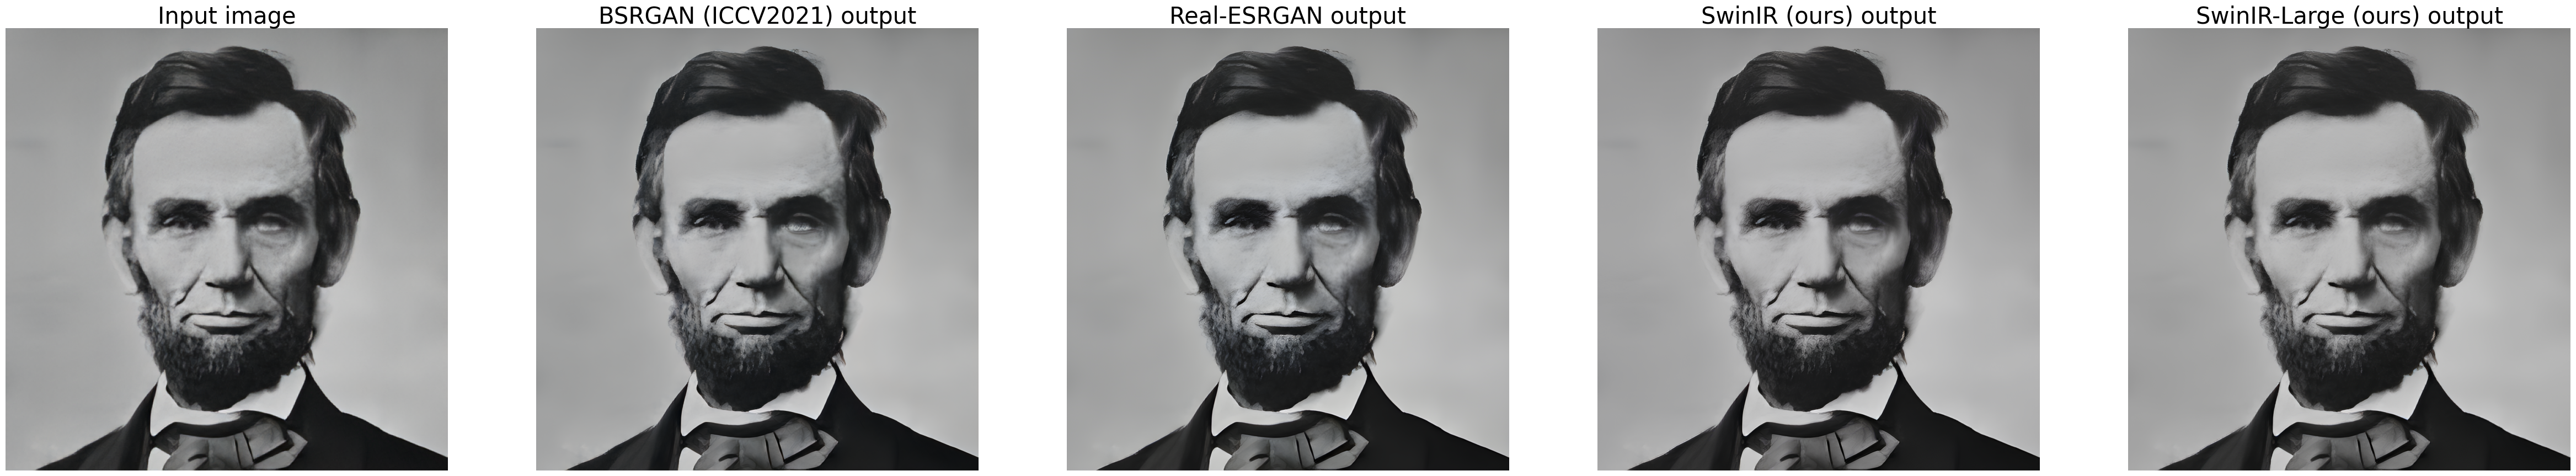

In [11]:
# utils for visualization
import cv2
import matplotlib.pyplot as plt
def display(img1, img2):
  total_figs = 5
  fig = plt.figure(figsize=(total_figs*12, 14))
  ax1 = fig.add_subplot(1, total_figs, 1)
  plt.title('Input image', fontsize=30)
  ax1.axis('off')
  ax2 = fig.add_subplot(1, total_figs, 2)
  plt.title('BSRGAN (ICCV2021) output', fontsize=30)
  ax2.axis('off')
  ax3 = fig.add_subplot(1, total_figs, 3)
  plt.title('Real-ESRGAN output', fontsize=30)
  ax3.axis('off')
  ax4 = fig.add_subplot(1, total_figs, 4)
  plt.title('SwinIR (ours) output', fontsize=30)
  ax4.axis('off')
  ax5 = fig.add_subplot(1, total_figs, 5)
  plt.title('SwinIR-Large (ours) output', fontsize=30)
  ax5.axis('off')
  ax1.imshow(img1)
  ax2.imshow(img2['BSRGAN'])
  ax3.imshow(img2['realESRGAN'])
  ax4.imshow(img2['SwinIR'])
  ax5.imshow(img2['SwinIR-L'])

def imread(img_path):
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  return img

# display each image in the upload folder
print('Note: BSRGAN may be better at face restoration, but worse at building restoration because it uses different datasets in training.')
if test_patch_wise:
  print('BSRGAN does not support "test_patch_wise" mode for now. Set test_patch_wise = False to see its results.\n')
else:
  print('\n')
input_folder = upload_folder
result_folder = 'results/SwinIR'
input_list = sorted(glob.glob(os.path.join(input_folder, '*')))
output_list = sorted(glob.glob(os.path.join(result_folder, '*')))
for input_path, output_path in zip(input_list, output_list):
  img_input = imread(input_path)
  img_output = {}
  img_output['SwinIR'] = imread(output_path)
  img_output['SwinIR-L'] = imread(output_path.replace('SwinIR/', 'SwinIR_large/').replace('SwinIR.png', 'SwinIR_large.png'))
  if test_patch_wise:
    img_output['BSRGAN'] = img_output['SwinIR']*0+255
  else:
    img_output['BSRGAN'] = imread(output_path.replace('SwinIR', 'BSRGAN'))
  path = output_path.replace('/SwinIR/', '/realESRGAN/').replace('_SwinIR.png','_out{}'.format(os.path.splitext(input_path)[1]))
  if os.path.exists(path):
    shutil.move(path, path.replace('_out.', '_realESRGAN.'))
  img_output['realESRGAN'] = imread(path.replace('_out.', '_realESRGAN.'))

  display(img_input, img_output)

# 5. Download Results


In [12]:
# Download the results
zip_filename = 'SwinIR_result.zip'
if os.path.exists(zip_filename):
  os.remove(zip_filename)
os.system(f"zip -r -j {zip_filename} results/*")
files.download(zip_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>